##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Generating Images with BigBiGAN


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/bigbigan_with_tf_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/bigbigan_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/bigbigan_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/bigbigan_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=experts%2Fbert"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook is a demo for the *BigBiGAN* models available on [TF Hub](https://tfhub.dev/s?publisher=deepmind&q=bigbigan).

BigBiGAN extends standard (Big)GANs by adding an *encoder* module which can be used for unsupervised representation learning. Roughly speaking, the encoder inverts the generator by predicting latents `z` given real data `x`. See the [BigBiGAN paper on arXiv](https://arxiv.org/abs/1907.02544) [1] for more information about these models.

After connecting to a runtime, get started by following these instructions:

1. (Optional) Update the selected **`module_path`** in the first code cell below to load a BigBiGAN generator for a different encoder architecture.
2. Click **Runtime > Run all** to run each cell in order. Afterwards, the outputs, including visualizations of BigBiGAN samples and reconstructions, should automatically appear below.

Note: if you run into any issues, it can help to click **Runtime > Restart and run all...** to restart your runtime and rerun all cells from scratch.

[1] Jeff Donahue and Karen Simonyan. [Large Scale Adversarial Representation Learning](https://arxiv.org/abs/1907.02544). *arxiv:1907.02544*, 2019.

First, set the module path.
By default, we load the BigBiGAN model with the smaller ResNet-50-based encoder from  **`https://tfhub.dev/deepmind/bigbigan-resnet50/1`**.
To load the larger RevNet-50-x4 based model used to achieve the best representation learning results, comment out the active **`module_path`** setting and uncomment the other.

In [1]:
module_path = 'https://tfhub.dev/deepmind/bigbigan-resnet50/1'  # ResNet-50
# module_path = 'https://tfhub.dev/deepmind/bigbigan-revnet50x4/1'  # RevNet-50 x4

## Setup

In [2]:
import io
import IPython.display
import PIL.Image
from pprint import pformat
import time
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

Instructions for updating:
non-resource variables are not supported in the long term


## Define some functions to display images

In [3]:
def imgrid(imarray, cols=4, pad=1, padval=255, row_major=True):
  """Lays out a [N, H, W, C] image array as a single image grid."""
  pad = int(pad)
  if pad < 0:
    raise ValueError('pad must be non-negative')
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = N // cols + int(N % cols != 0)
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=padval)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

def interleave(*args):
  """Interleaves input arrays of the same shape along the batch axis."""
  if not args:
    raise ValueError('At least one argument is required.')
  a0 = args[0]
  if any(a.shape != a0.shape for a in args):
    raise ValueError('All inputs must have the same shape.')
  if not a0.shape:
    raise ValueError('Inputs must have at least one axis.')
  out = np.transpose(args, [1, 0] + list(range(2, len(a0.shape) + 1)))
  out = out.reshape(-1, *a0.shape[1:])
  return out

def imshow(a, format='png', jpeg_fallback=True):
  """Displays an image in the given format."""
  a = a.astype(np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(a).save(data, format)
  im_data = data.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def image_to_uint8(x):
  """Converts [-1, 1] float array to [0, 255] uint8."""
  x = np.asarray(x)
  x = (256. / 2.) * (x + 1.)
  x = np.clip(x, 0, 255)
  x = x.astype(np.uint8)
  return x

## Load a BigBiGAN TF Hub module and display its available functionality

In [4]:
# module = hub.Module(module_path, trainable=True, tags={'train'})  # training
start = time.clock()
module = hub.Module(module_path)  # inference
model_load_time = time.clock() - start

for signature in module.get_signature_names():
  print('Signature:', signature)
  print('Inputs:', pformat(module.get_input_info_dict(signature)))
  print('Outputs:', pformat(module.get_output_info_dict(signature)))
  print()

Signature: default
Inputs: {'x': <hub.ParsedTensorInfo shape=(?, 256, 256, 3) dtype=float32 is_sparse=False>}
Outputs: {'default': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=False>}

Signature: discriminate
Inputs: {'x': <hub.ParsedTensorInfo shape=(?, 128, 128, 3) dtype=float32 is_sparse=False>,
 'z': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=False>}
Outputs: {'score_x': <hub.ParsedTensorInfo shape=(?,) dtype=float32 is_sparse=False>,
 'score_xz': <hub.ParsedTensorInfo shape=(?,) dtype=float32 is_sparse=False>,
 'score_z': <hub.ParsedTensorInfo shape=(?,) dtype=float32 is_sparse=False>}

Signature: encode
Inputs: {'x': <hub.ParsedTensorInfo shape=(?, 256, 256, 3) dtype=float32 is_sparse=False>}
Outputs: {'avepool_feat': <hub.ParsedTensorInfo shape=(?, 2048) dtype=float32 is_sparse=False>,
 'bn_crelu_feat': <hub.ParsedTensorInfo shape=(?, 4096) dtype=float32 is_sparse=False>,
 'default': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=F

## Define a wrapper class for convenient access to various functions

In [5]:
class BigBiGAN(object):

  def __init__(self, module):
    """Initialize a BigBiGAN from the given TF Hub module."""
    self._module = module

  def generate(self, z, upsample=False):
    """Run a batch of latents z through the generator to generate images.

    Args:
      z: A batch of 120D Gaussian latents, shape [N, 120].

    Returns: a batch of generated RGB images, shape [N, 128, 128, 3], range
      [-1, 1].
    """
    outputs = self._module(z, signature='generate', as_dict=True)
    return outputs['upsampled' if upsample else 'default']

  def make_generator_ph(self):
    """Creates a tf.placeholder with the dtype & shape of generator inputs."""
    info = self._module.get_input_info_dict('generate')['z']
    return tf.placeholder(dtype=info.dtype, shape=info.get_shape())

  def gen_pairs_for_disc(self, z):
    """Compute generator input pairs (G(z), z) for discriminator, given z.

    Args:
      z: A batch of latents (120D standard Gaussians), shape [N, 120].

    Returns: a tuple (G(z), z) of discriminator inputs.
    """
    # Downsample 256x256 image x for 128x128 discriminator input.
    x = self.generate(z)
    return x, z

  def encode(self, x, return_all_features=False):
    """Run a batch of images x through the encoder.

    Args:
      x: A batch of data (256x256 RGB images), shape [N, 256, 256, 3], range
        [-1, 1].
      return_all_features: If True, return all features computed by the encoder.
        Otherwise (default) just return a sample z_hat.

    Returns: the sample z_hat of shape [N, 120] (or a dict of all features if
      return_all_features).
    """
    outputs = self._module(x, signature='encode', as_dict=True)
    return outputs if return_all_features else outputs['z_sample']

  def make_encoder_ph(self):
    """Creates a tf.placeholder with the dtype & shape of encoder inputs."""
    info = self._module.get_input_info_dict('encode')['x']
    return tf.placeholder(dtype=info.dtype, shape=info.get_shape())

  def enc_pairs_for_disc(self, x):
    """Compute encoder input pairs (x, E(x)) for discriminator, given x.

    Args:
      x: A batch of data (256x256 RGB images), shape [N, 256, 256, 3], range
        [-1, 1].

    Returns: a tuple (downsample(x), E(x)) of discriminator inputs.
    """
    # Downsample 256x256 image x for 128x128 discriminator input.
    x_down = tf.nn.avg_pool(x, ksize=2, strides=2, padding='SAME')
    z = self.encode(x)
    return x_down, z

  def discriminate(self, x, z):
    """Compute the discriminator scores for pairs of data (x, z).

    (x, z) must be batches with the same leading batch dimension, and joint
      scores are computed on corresponding pairs x[i] and z[i].

    Args:
      x: A batch of data (128x128 RGB images), shape [N, 128, 128, 3], range
        [-1, 1].
      z: A batch of latents (120D standard Gaussians), shape [N, 120].

    Returns:
      A dict of scores:
        score_xz: the joint scores for the (x, z) pairs.
        score_x: the unary scores for x only.
        score_z: the unary scores for z only.
    """
    inputs = dict(x=x, z=z)
    return self._module(inputs, signature='discriminate', as_dict=True)

  def reconstruct_x(self, x, use_sample=True, upsample=False):
    """Compute BigBiGAN reconstructions of images x via G(E(x)).

    Args:
      x: A batch of data (256x256 RGB images), shape [N, 256, 256, 3], range
        [-1, 1].
      use_sample: takes a sample z_hat ~ E(x). Otherwise, deterministically
        use the mean. (Though a sample z_hat may be far from the mean z,
        typically the resulting recons G(z_hat) and G(z) are very
        similar.
      upsample: if set, upsample the reconstruction to the input resolution
        (256x256). Otherwise return the raw lower resolution generator output
        (128x128).

    Returns: a batch of recons G(E(x)), shape [N, 256, 256, 3] if
      `upsample`, otherwise [N, 128, 128, 3].
    """
    if use_sample:
      z = self.encode(x)
    else:
      z = self.encode(x, return_all_features=True)['z_mean']
    recons = self.generate(z, upsample=upsample)
    return recons

  def losses(self, x, z):
    """Compute per-module BigBiGAN losses given data & latent sample batches.

    Args:
      x: A batch of data (256x256 RGB images), shape [N, 256, 256, 3], range
        [-1, 1].
      z: A batch of latents (120D standard Gaussians), shape [M, 120].

    For the original BigBiGAN losses, pass batches of size N=M=2048, with z's
    sampled from a 120D standard Gaussian (e.g., np.random.randn(2048, 120)),
    and x's sampled from the ImageNet (ILSVRC2012) training set with the
    "ResNet-style" preprocessing from:

        https://github.com/tensorflow/tpu/blob/master/models/official/resnet/resnet_preprocessing.py

    Returns:
      A dict of per-module losses:
        disc: loss for the discriminator.
        enc: loss for the encoder.
        gen: loss for the generator.
    """
    # Compute discriminator scores on (x, E(x)) pairs.
    # Downsample 256x256 image x for 128x128 discriminator input.
    scores_enc_x_dict = self.discriminate(*self.enc_pairs_for_disc(x))
    scores_enc_x = tf.concat([scores_enc_x_dict['score_xz'],
                              scores_enc_x_dict['score_x'],
                              scores_enc_x_dict['score_z']], axis=0)

    # Compute discriminator scores on (G(z), z) pairs.
    scores_gen_z_dict = self.discriminate(*self.gen_pairs_for_disc(z))
    scores_gen_z = tf.concat([scores_gen_z_dict['score_xz'],
                              scores_gen_z_dict['score_x'],
                              scores_gen_z_dict['score_z']], axis=0)

    disc_loss_enc_x = tf.reduce_mean(tf.nn.relu(1. - scores_enc_x))
    disc_loss_gen_z = tf.reduce_mean(tf.nn.relu(1. + scores_gen_z))
    disc_loss = disc_loss_enc_x + disc_loss_gen_z

    enc_loss = tf.reduce_mean(scores_enc_x)
    gen_loss = tf.reduce_mean(-scores_gen_z)

    return dict(disc=disc_loss, enc=enc_loss, gen=gen_loss)

## Create tensors to be used later for computing samples, reconstructions, discriminator scores, and losses

In [6]:
bigbigan = BigBiGAN(module)

# Make input placeholders for x (`enc_ph`) and z (`gen_ph`).
enc_ph = bigbigan.make_encoder_ph()
gen_ph = bigbigan.make_generator_ph()

# Compute samples G(z) from encoder input z (`gen_ph`).
gen_samples = bigbigan.generate(gen_ph)

# Compute reconstructions G(E(x)) of encoder input x (`enc_ph`).
recon_x = bigbigan.reconstruct_x(enc_ph, upsample=True)

# Compute encoder features used for representation learning evaluations given
# encoder input x (`enc_ph`).
enc_features = bigbigan.encode(enc_ph, return_all_features=True)

# Compute discriminator scores for encoder pairs (x, E(x)) given x (`enc_ph`)
# and generator pairs (G(z), z) given z (`gen_ph`).
disc_scores_enc = bigbigan.discriminate(*bigbigan.enc_pairs_for_disc(enc_ph))
disc_scores_gen = bigbigan.discriminate(*bigbigan.gen_pairs_for_disc(gen_ph))

# Compute losses.
losses = bigbigan.losses(enc_ph, gen_ph)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Create a TensorFlow session and initialize variables

In [7]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Generator samples

First, we'll visualize samples from the pretrained BigBiGAN generator by sampling generator inputs `z` from a standard Gaussian (via `np.random.randn`) and displaying the images it produces. So far we're not going beyond the capabilites of a standard GAN -- we're just using the generator (and ignoring the encoder) for now.

samples shape: (32, 128, 128, 3)


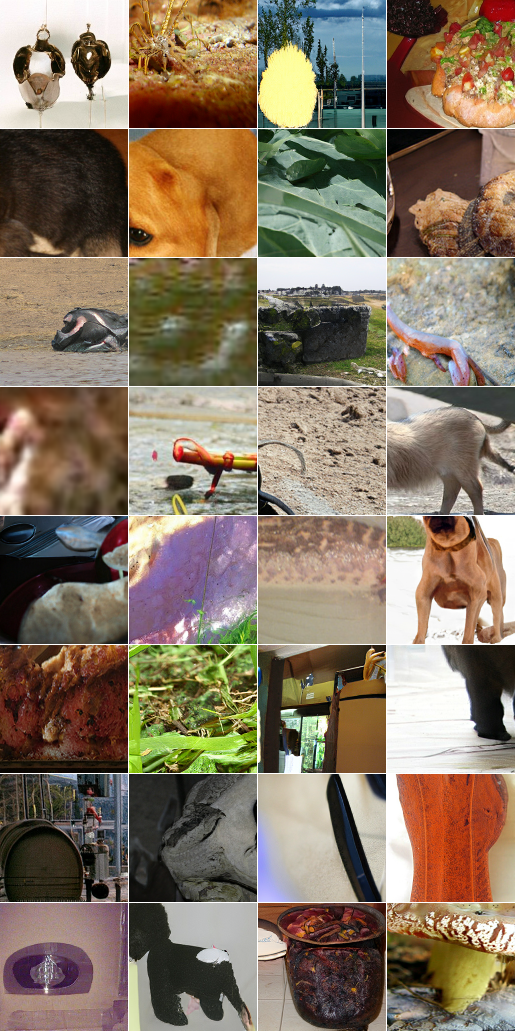

In [8]:
feed_dict = {gen_ph: np.random.randn(32, 120)}
_out_samples = sess.run(gen_samples, feed_dict=feed_dict)
print('samples shape:', _out_samples.shape)
imshow(imgrid(image_to_uint8(_out_samples), cols=4))

# Load `test_images` from the TF-Flowers dataset

BigBiGAN is trained on ImageNet, but as it's too large to work with in this demo, we use the smaller TF-Flowers [1] dataset as our inputs for visualizing reconstructions and computing encoder features.

In this cell we load TF-Flowers (downloading the dataset if needed) and store a fixed batch of 256x256 RGB image samples in a NumPy array `test_images`.

[1] https://www.tensorflow.org/datasets/catalog/tf_flowers

In [9]:
from tqdm import tqdm as tqdm

start = time.clock()
download_time = time.clock() - time.clock()
for i in range(1):
  def get_flowers_data():
    """Returns a [32, 256, 256, 3] np.array of preprocessed TF-Flowers samples."""
    start_download = time.clock()
    import tensorflow_datasets as tfds
    ds, info = tfds.load('tf_flowers', split='train', with_info=True)
    download_time = time.clock() - start_download
    ds = ds.map(lambda x: x['image'])
    ds = ds.filter(lambda x: tf.reduce_min(tf.shape(x)[:2]) >= 256)
    def crop_and_resize(image):
      imsize = tf.shape(image)[:2]
      minor_edge = tf.reduce_min(imsize)
      start = (imsize - minor_edge) // 2
      stop = start + minor_edge
      cropped_image = image[start[0] : stop[0], start[1] : stop[1]]
      resized_image = tf.image.resize_bicubic([cropped_image], [256, 256])[0]
      return resized_image
    ds = ds.map(crop_and_resize)
    ds = ds.map(lambda image: tf.cast(image, tf.float32) / (255. / 2.) - 1)
    ds = ds.take(32)
    return np.array(list(tfds.as_numpy(ds)))
test_images = get_flowers_data()
data_load_time = time.clock() - start - download_time

# Reconstructions

Now we visualize BigBiGAN reconstructions by passing real images through the encoder and back through the generator, computing `G(E(x))` given images `x`.
Below, input images `x` are shown in the left column, and corresponding reconstructions are shown on the right.

Note that reconstructions are not pixel-perfect matches to the input images; rather, they tend to capture the higher level semantic content of the input while "forgetting" most of the low-level detail. This suggests the BigBiGAN encoder may learn to capture the types of high level semantic information about images that we'd like to see in a representation learning approach.

Also note that the raw reconstructions of the 256x256 input images are at the lower resolution produced by our generator -- 128x128. We upsample them for visualization purposes.

In [10]:
start = time.clock()
for i in range(1):
  test_images_batch = test_images[:16]
  _out_recons = sess.run(recon_x, feed_dict={enc_ph: test_images_batch})
  inputs_and_recons = interleave(test_images_batch, _out_recons)
data_load_time = data_load_time + time.clock() - start

# Encoder features

We now demonstrate how to compute features from the encoder used for standard representation learning evaluations.

These features could be used in a linear or nearest neighbors-based classifier. We include the standard feature taken after the global average pooling (key `avepool_feat`) as well as the larger "BN+CReLU" feature (key `bn_crelu_feat`) used to achieve the best results.

In [11]:
start = time.clock()
for i in range(1):
  _out_features = sess.run(enc_features, feed_dict={enc_ph: test_images_batch})
inference_time = time.clock() - start
total_load_time = data_load_time + model_load_time

print('Model loading time {}s'.format(model_load_time))
print('Data loading time {}s'.format(data_load_time))
print('Total loading time {}s'.format(total_load_time))
print('Inference time {}s'.format(inference_time))

Model loading time 6.631056999999999s
Data loading time 65.30556999999999s
Total loading time 71.93662699999999s
Inference time 8.363772000000012s


# Discriminator scores and losses

Finally, we'll compute the discriminator scores and losses on batches of encoder and generator pairs. These losses could be passed into an optimizer to train BigBiGAN.

We use our batch of images above as the encoder inputs `x`, computing the encoder score as `D(x, E(x))`. For the generator inputs we sample `z` from a 120D standard Gaussian via `np.random.randn`, computing the generator score as `D(G(z), z)`.

The discriminator predicts a joint score `score_xz` for the `(x, z)` pairs as well as unary scores `score_x` and `score_z` for `x` and `z` alone, respectively. It's trained to give high (positive) scores to encoder pairs and low (negative) scores to generator pairs. This mostly holds below, though the unary `score_z` is negative in both cases, indicating that the encoder outputs `E(x)` resemble actual samples from a Gaussian.

In [ ]:
feed_dict = {enc_ph: test_images, gen_ph: np.random.randn(32, 120)}
_out_scores_enc, _out_scores_gen, _out_losses = sess.run(
    [disc_scores_enc, disc_scores_gen, losses], feed_dict=feed_dict)
print('Encoder scores:', {k: v.mean() for k, v in _out_scores_enc.items()})
print('Generator scores:', {k: v.mean() for k, v in _out_scores_gen.items()})
print('Losses:', _out_losses)